In [4]:
from IPython.utils import io
with io.capture_output() as output_03:
    %run '03_2d_spectra.ipynb'

In [5]:
from time import clock
print('Current CPU time: %.1f seconds' % (clock()))

Current CPU time: 101.3 seconds


### Show the data (we want to know what we're talking about)

This is just a quick reminder: we show the data with and without NG.

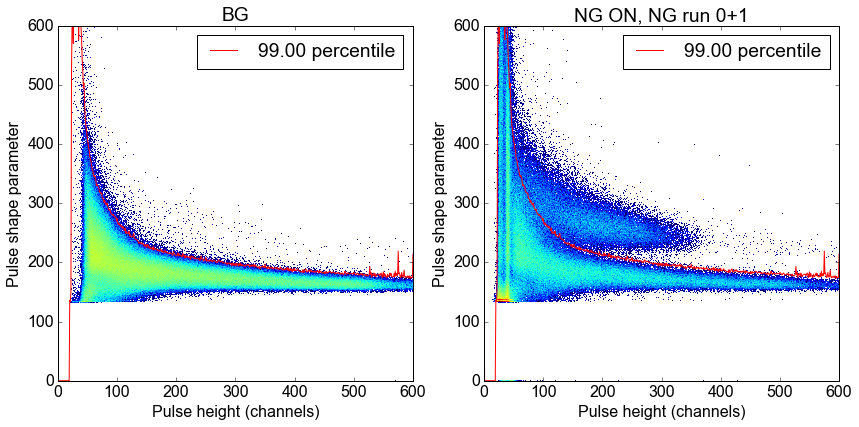

In [6]:
plt.figure(figsize=(14,10))
plt.subplot(121)
im = plt.imshow(spec2d_bg, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
for cut, color in zip(cut_list, ['red', 'orange', 'green', 'purple', 'black']):
    cut.plot_percentile(label='%.2f percentile' % cut.pct, color=color)
#plt.colorbar()
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('BG')
plt.legend()
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')

plt.subplot(122)
im = plt.imshow(spec2d, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
for cut, color in zip(cut_list, ['red', 'orange', 'green', 'purple', 'black']):
    cut.plot_percentile(label='%.2f percentile' % cut.pct, color=color)
#plt.colorbar()
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('NG ON, NG run 0+1')
plt.legend()
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')

plt.show()

### Get the acceptance for one energy

This is where we define the most important function: it computes the acceptance. This is done in a few steps:
  * First, combined multiple bins in x if this is requested (increase stats)
  * Next, subtract background from NG on data, scaled by livetimes and propagating the errrors
  * Then fit the resulting spectrum with a single gaussian and sensible guess values. Fit range can be specified.
  * To compute the acceptance, check the fraction over threshold. Currently this is just one fixed value, maybe average over the bins used?

In [7]:
# simple auxilary function: unnormalized Gaussian
def single_gaussian(x, a, mu, sigma):
    return a*gaussian(x,mu,sigma)

In [8]:
def better_method(i=150, i_plusminus=2, fit_range=(132, 500), cut = cut_list[0], plot=True, verbose=True, 
                  method='fit'):
    
    if verbose:
        print('Will check acceptance for bin %d, i.e. %.1f keVee.' % (i, e_scale[i]))
        print('Averaging +- %d bins, so +- %.1f keVee'% (i_plusminus, e_scale[i+i_plusminus] - e_scale[i]))
        print('The cut used is the %.2f acceptance cut.' % (cut.pct))
    
    # Build empty arrays to hold fg and bg slice
    slice_fg = np.zeros(len(spec2d[:,i]), dtype=float)
    slice_bg = np.zeros(len(spec2d_bg[:,i]), dtype=float)

    # Fill them
    for j in np.arange(i - i_plusminus, i + i_plusminus + 0.001, 1.):
        slice_fg += spec2d[:, j]
        slice_bg += spec2d_bg[:,j]
    
    # Errors...
    # per-bin Poissonian errors
    # Note that the err is normalized, but the counts (in 'slice' is NOT yet, will do that later...)
    slice_fg_err = 1/fg_livetime * np.sqrt(slice_fg)
    slice_bg_err = 1/bg_livetime * np.sqrt(slice_bg)
    
    # If zero entries, set error equal to error if one count
    # Please excuse the poor programmer/physisist's approach to statistics. I know this is not proper
    for j in range(len(slice_fg_err)):
        if slice_fg_err[j] == 0:
            slice_fg_err[j] = 1/fg_livetime
    for j in range(len(slice_bg_err)):
        if slice_bg_err[j] == 0:
            slice_bg_err[j] = 1/bg_livetime
    # For the subtraction add the absolute errors in quadrature    
    slice_sub_err = (slice_fg_err**2 + slice_bg_err**2)**(0.5)
    
    # Normalize (later is here)
    slice_fg = 1/fg_livetime * slice_fg
    slice_bg = 1/bg_livetime * slice_bg
    slice_sub = slice_fg - slice_bg
    
    # Now fit it
    p0 = [sum(slice_sub), np.argmax(slice_sub), 20]
    if verbose: print('Fit parameter guess:', p0)
    popt, pcov = curve_fit(single_gaussian, np.arange(fit_range[0], fit_range[1]),
                            slice_sub[fit_range[0]:fit_range[1]], p0=p0, 
                           sigma=slice_sub_err[fit_range[0]:fit_range[1]])
    perr = np.sqrt(np.diag(pcov))
    if verbose: print('Fit parameters, proper:', popt)
    if verbose: print('Errors: ', perr)
    if verbose: print(pcov)
    
    # For acc determination
    th = cut.pct_list[i]
    th_list = [cut.pct_list[int(j)] for j in np.arange(i - i_plusminus, i + i_plusminus+0.001, 1 )]
    th = np.average(th)
    if verbose: print('Threshold: ', th)
    if verbose: print('Threshold list: ', th_list)
    
    # Method #1: just sum all above threshold.
    acc_raw = sum(slice_sub[th:]) / sum(slice_sub)
    
    # Integrate to get acceptance
    def integrand(x):
        return single_gaussian(x, popt[0], popt[1],popt[2])
    
    def int_gauss(function, threshold, start=0, end=1000):
        from scipy.integrate import quad
        return quad(integrand, threshold, end)[0] / quad(integrand, start, end)[0]
    
    # Compute bet-fit acceptance
    acc_fit = int_gauss(single_gaussian, th, 0, 1000)
    
    # (over)estimate error: try mu +- sigma_mu and sigma +- sigma_sigma and all combinations
    acc_list = []
    for sigma_dir in (-1, 0, +1):
        for mu_dir in (-1, 0, +1):
            # Redefine integrand
            def integrand(x):
                return single_gaussian(x, popt[0], popt[1] + mu_dir*perr[1], popt[2] + sigma_dir*perr[2])
            acc_list.append(int_gauss(single_gaussian, th, 0, 1000))
    # Worst case errors
    acc_fit_err_plus = max(acc_list) - acc_fit
    acc_fit_err_min = acc_fit - min(acc_list)
    
    if verbose: print('Acc raw method: ', acc_raw)
    if verbose: print('Acc fit method: ', acc_fit)
    if verbose: print('Acc errors: + %f and - %f' % (acc_fit_err_plus, acc_fit_err_min))
    if verbose: print('Acc list fit method: ', acc_list)
        
    

    
    if plot:
        plt.plot([x for x in range(len(slice_sub))], slice_sub)
        plt.plot([single_gaussian(x, *popt) for x in range(len(slice_sub))])
        for l in fit_range:
            plt.axvline(l, color='red', ls='--',lw=2, label='fit range')
        plt.axvline(cut.pct_list[i], c='orange')
        plt.show()
    if method == 'fit':
        # Return value and errors
        return acc_fit, acc_fit_err_plus, acc_fit_err_min
    elif method == 'raw':
        return acc_raw
    else:
        raise ValueError('What method did YOU pick? I found this: %s' % method)
        

Will check acceptance for bin 90, i.e. 200.6 keVee.
Averaging +- 2 bins, so +- 4.8 keVee
The cut used is the 99.00 acceptance cut.
Fit parameter guess: [0.18359024901299398, 305, 20]
Fit parameters, proper: [  1.59741390e-01   3.03455645e+02   3.89712356e+01]
Errors:  [ 0.00358848  1.10498378  0.83959452]
[[  1.28772071e-05  -1.91005902e-03   1.32246126e-03]
 [ -1.91005902e-03   1.22098916e+00  -5.24323807e-01]
 [  1.32246126e-03  -5.24323807e-01   7.04918955e-01]]
Threshold:  283.0
Threshold list:  [290, 285, 283, 281, 281]
Acc raw method:  0.661050158537
Acc fit method:  0.7001704678574227
Acc errors: + 0.013938 and - 0.013631
Acc list fit method:  [0.6940874379326402, 0.704175542225522, 0.7141080477099541, 0.6902422156137825, 0.7001704678574227, 0.7099520650787522, 0.6865395520416212, 0.6963114698713131, 0.7059450229162458]


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


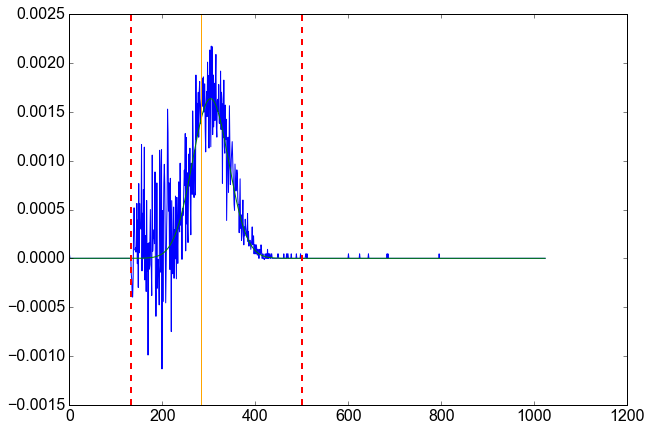

(0.7001704678574227, 0.013937579852531412, 0.013630915815801448)

In [9]:
better_method(i=90)

In [10]:
def scan_acc(i_min, i_max, i_step, i_plusminus, method, verbose=False, plot=False,fit_range=(132, 500)):
    scanned_e = []
    scanned_list = []
    errs_plus = []
    errs_min = []
    for i in range(i_min, i_max, i_step):
        scanned_e.append(e_scale[i])
        acc, err_plus, err_min = (better_method(i, i_plusminus=i_plusminus,verbose=verbose, plot=plot, method=method,
                                         fit_range = fit_range))
        scanned_list.append(acc)
        errs_plus.append(err_plus)
        errs_min.append(err_min)
    return np.array(scanned_e), np.array(scanned_list), np.array(errs_plus), np.array(errs_min)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


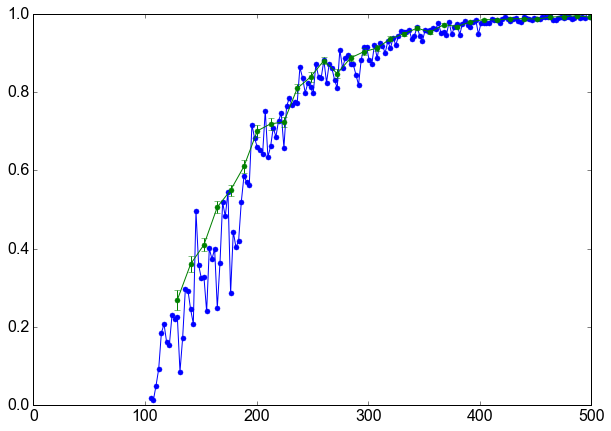

In [11]:
x_acc, y_acc, dy_acc_plus, dy_acc_min = (scan_acc(60, 300,5, 2, 'fit', plot=False, fit_range=(200, 400)))

plt.plot(acc_thresholds_energy, acc_acceptances, marker='.', markersize=10, label='Double Gauss method')
plt.errorbar(x_acc, y_acc, (dy_acc_plus, dy_acc_min), marker='.', markersize=10, label='Single Gauss method')

plt.xlim(0,500)
plt.ylim(0,1)
plt.show()


In [12]:
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

cutoff = 1
fs = 10
acc_smooth = butter_lowpass_filtfilt(y_acc, cutoff, fs)
acc_smooth_plus = butter_lowpass_filtfilt(y_acc + dy_acc_plus, cutoff, fs)
acc_smooth_min = butter_lowpass_filtfilt(y_acc - dy_acc_min, cutoff, fs)
acc_smooth_plus2 = butter_lowpass_filtfilt(y_acc + 2* dy_acc_plus, cutoff, fs)
acc_smooth_min2 = butter_lowpass_filtfilt(y_acc - 2*dy_acc_min, cutoff, fs)

In [13]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return average, np.sqrt(variance)

In [17]:
acc_e = np.interp(e_scale, x_acc, acc_smooth, left = 0, right = 1.)
acc_e_plus = np.interp(e_scale, x_acc, acc_smooth_plus, left = 0, right = 1.)
acc_e_plus2 = np.interp(e_scale, x_acc, acc_smooth_plus2, left = 0, right = 1.)
acc_e_min = np.interp(e_scale, x_acc, acc_smooth_min, left = 0, right = 1.)
acc_e_min2 = np.interp(e_scale, x_acc, acc_smooth_min2, left = 0, right = 1.)

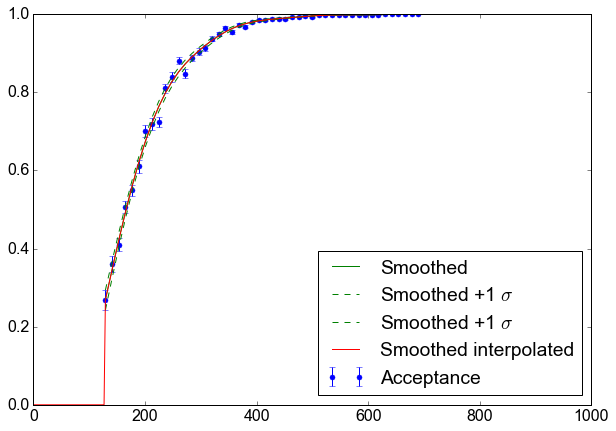

In [15]:
plt.errorbar(x_acc, y_acc, (dy_acc_plus, dy_acc_min), marker='.', markersize=10, ls='None', label='Acceptance')
plt.plot(x_acc, acc_smooth,color='green',label='Smoothed')
plt.plot(x_acc, acc_smooth_plus,color='green', ls='--',label='Smoothed +1 $\sigma$')
plt.plot(x_acc, acc_smooth_min,color='green', ls='--',label='Smoothed +1 $\sigma$')
plt.plot(e_scale, acc_e, label='Smoothed interpolated', color='red')
plt.xlim(0,1000)
plt.legend(loc='lower right')
plt.title('Money plot for this notebook')


### DEPRICATED

Not-so-well working method of first fitting a Gaussian to BG-only, then using that information for a double-gaussian fit.
I guess I forgot that I can actually scale, because we have the livetime...

In [16]:
def get_e_acc(i, i_plusminus, cut = cut_list[0], verbose=True, plot=True):
    fit_min = 132 # Need thisw cause there is some cutoff... From here it is nonzero

    print('Will check acceptance for bin %d, i.e. %.1f keVee.' % (i, e_scale[i]))
    print('Averaging +- %d bins, so +- %.1f keVee'% (i_plusminus, e_scale[i+i_plusminus] - e_scale[i]))
    slice_fg = np.zeros(len(spec2d[:,i]), dtype=float)
    slice_bg = np.zeros(len(spec2d_bg[:,i]), dtype=float)


    for j in np.arange(i - i_plusminus, i + i_plusminus + 0.001, 1.):
        slice_fg += spec2d[:, j]
        slice_bg += spec2d_bg[:,j]
    # Normalization
    slice_fg = 1/sum(slice_fg) * slice_fg
    slice_bg = 1/sum(slice_bg) * slice_bg

    # First fit BG
    # Let's get some proper guess values. These are self-evident :)
    p0_bg = [1, weighted_avg_and_std(range(len(slice_bg)), slice_bg)[0],
            weighted_avg_and_std(range(len(slice_bg)), slice_bg)[1]]
    print('Guess values single gaussian BG:')
    print(p0_bg)

    # Gaussian fit of BG
    popt_bg, pcov_bg = curve_fit(single_gaussian, np.arange(fit_min, len(slice_bg)), slice_bg[fit_min:], p0=p0_bg)
    print('Fit values BG:')
    print(popt_bg)

    # Fit with proper guess values..
    p0_fg = [0.5, popt_bg[1], popt_bg[2], 0.5, 300, 20 ]
    popt_fg, pcov_fg = curve_fit(double_gaussian, np.arange(fit_min, len(slice_fg)), slice_fg[fit_min:], p0=p0_fg)
    print('Fit values double gaussian:')
    print(popt_fg)

    # Or... Fix mu and sigma of Gaussian dist.
    def constrained_double_gaussian(x, a1, a2, mu2, sigma2):
        return a1*gaussian(x, popt_bg[1], popt_bg[2]) + a2*gaussian(x, mu2, sigma2)

    def bg_sub_single_gaussian(x, a1, a2, mu2, sigma2):
        return a1*slice_bg[x] + a2*gaussian(x, mu2, sigma2)

    p0_fg_cons = [0.5, 0.5, 300, 20]
    popt_fg_cons, pcov_fg_cons = curve_fit(constrained_double_gaussian, np.arange(fit_min, len(slice_fg)), slice_fg[fit_min:],
                                           p0=p0_fg_cons)
    print('Fit values double gaussian, constrained:')
    print(popt_fg_cons)

    p0_fg_sub = [0.5, 0.5, 300, 20]
    popt_fg_sub, pcov_fg_sub = curve_fit(bg_sub_single_gaussian, np.arange(fit_min, len(slice_fg)), slice_fg[fit_min:],
                                         p0=p0_fg_sub)
    print('Fit values subtracted gaussian:')
    print(popt_fg_sub)


    plt.plot(slice_fg)
    plt.plot(slice_bg)
    plt.plot([single_gaussian(x, *popt_bg) for x in range(len(slice_bg))], color='green', lw=2, label='BG fit')
    # plt.plot([double_gaussian(x, *popt_fg) for x in range(len(slice_fg))], color='red', lw=2)
    plt.plot([constrained_double_gaussian(x, *popt_fg_cons) 
              for x in range(len(slice_fg))], color='blue', lw=2, label='Fixed position')
    plt.plot([bg_sub_single_gaussian(x, *popt_fg_sub) 
              for x in range(len(slice_fg))], color='red', lw=2, label='Subtracted')



    plt.axvline(cut.pct_list[i], lw=2, ls='--', c='r')
    plt.xlim(0,500)
    plt.ylim()
    plt.xlabel('Discrimination parameter')
    plt.ylabel('Counts per unit of disc. parameter')
    #plt.text(250, 24, 'Energy bin %d = %.1f keVee' % (i, e_scale[i]))
    #plt.text(250, 22, 'Acceptance %.2f%%' % (100*get_acceptance(cut.pct_list[i], *popt)))
    plt.legend()